In [1]:
import pandas as pd
import geopandas as gd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import rasterio
import rasterio.warp
from rasterio import features
import shapely.geometry
import shapely
import seaborn as sn

In [2]:
os.chdir('/projects/canis/eoc_feature_corr')

In [3]:
grid_path = "./data/by_state/MT/mt_extent_coverage.shp"
grid = gd.read_file(grid_path).to_crs('EPSG:3857')
grid = grid.set_index('id')

In [4]:
feature_path = './data/cover/NLCD_2016_Land_Cover_L48_20190424_3857.tiff'

feature_file = rasterio.open(feature_path)
feature_raster = feature_file.read(1)

In [5]:
feature_legend_path = './data/cover/NLCD_landcover_legend_2018_12_17_IGrpwzCAkFkyZtKBIu8z.csv'
feature_legend = pd.read_csv(feature_legend_path)
feature_legend = feature_legend.set_index('Value')
feature_legend = feature_legend.dropna()

In [15]:
grid['centroid'] = grid['geometry'].centroid
grid = grid.set_geometry('centroid')
grid['feature'] = grid['centroid'].map(lambda coords: next(feature_file.sample(coords.coords, indexes=1))[0])
grid = grid.set_geometry('geometry')
grid = grid.drop('centroid', axis=1)
grid

,left,top,right,bottom,med_rxpwr,chg_covera,verizon_co,geometry,feature,Legend,agreement
id,,,,,,,,,,,
585.0,-1.223775e+07,5.690753e+06,-1.223675e+07,5.689753e+06,-120.0,0,0,"POLYGON ((-12237752.373 5690752.630, -12236752...",42,Evergreen Forest,True
586.0,-1.223775e+07,5.689753e+06,-1.223675e+07,5.688753e+06,-120.0,0,1,"POLYGON ((-12237752.373 5689752.630, -12236752...",52,Shrub/Scrub,False
1235.0,-1.223675e+07,5.694753e+06,-1.223575e+07,5.693753e+06,-120.0,0,0,"POLYGON ((-12236752.373 5694752.630, -12235752...",52,Shrub/Scrub,True
1889.0,-1.223575e+07,5.694753e+06,-1.223475e+07,5.693753e+06,-120.0,0,0,"POLYGON ((-12235752.373 5694752.630, -12234752...",52,Shrub/Scrub,True
1895.0,-1.223575e+07,5.688753e+06,-1.223475e+07,5.687753e+06,-120.0,0,0,"POLYGON ((-12235752.373 5688752.630, -12234752...",52,Shrub/Scrub,True
...,...,...,...,...,...,...,...,...,...,...,...
428560.0,-1.158275e+07,6.085753e+06,-1.158175e+07,6.084753e+06,-120.0,0,1,"POLYGON ((-11582752.373 6085752.630, -11581752...",82,Cultivated Crops,False
428561.0,-1.158275e+07,6.084753e+06,-1.158175e+07,6.083753e+06,-120.0,0,1,"POLYGON ((-11582752.373 6084752.630, -11581752...",82,Cultivated Crops,False
428562.0,-1.158275e+07,6.083753e+06,-1.158175e+07,6.082753e+06,-120.0,0,1,"POLYGON ((-11582752.373 6083752.630, -11581752...",22,"Developed, Low Intensity",False


In [7]:
grid = grid.join(feature_legend, how="left", on='feature')

In [8]:
grid['agreement'] = grid['chg_covera'] == grid['verizon_co']

In [9]:
sn.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

In [10]:
confusion_matrix = pd.crosstab( grid['Legend'],grid['agreement'], rownames=['Cover Type'], colnames=['Agreement'], normalize='index')
print (confusion_matrix)

Agreement                         False     True 
Cover Type                                       
Barren Land                    0.714286  0.285714
Cultivated Crops               0.635370  0.364630
Deciduous Forest               0.615385  0.384615
Developed, High Intensity      0.750000  0.250000
Developed, Low Intensity       0.831461  0.168539
Developed, Medium Intensity    0.333333  0.666667
Developed, Open Space          0.812500  0.187500
Emergent Herbaceuous Wetlands  0.777174  0.222826
Evergreen Forest               0.687919  0.312081
Hay/Pasture                    0.840336  0.159664
Herbaceuous                    0.672713  0.327287
Mixed Forest                   1.000000  0.000000
Open Water                     0.500000  0.500000
Shrub/Scrub                    0.824116  0.175884
Woody Wetlands                 0.832061  0.167939


In [11]:
confusion_matrix['Total'] = grid.groupby('Legend').count()['agreement']

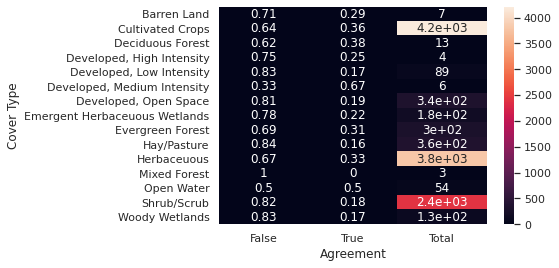

In [12]:
sn.heatmap(confusion_matrix, annot=True)
plt.show()

Agreement                      False  True    All
Cover Type                                       
Barren Land                        5     2      7
Cultivated Crops                2673  1534   4207
Deciduous Forest                   8     5     13
Developed, High Intensity          3     1      4
Developed, Low Intensity          74    15     89
Developed, Medium Intensity        2     4      6
Developed, Open Space            273    63    336
Emergent Herbaceuous Wetlands    143    41    184
Evergreen Forest                 205    93    298
Hay/Pasture                      300    57    357
Herbaceuous                     2559  1245   3804
Mixed Forest                       3     0      3
Open Water                        27    27     54
Shrub/Scrub                     1982   423   2405
Woody Wetlands                   109    22    131
All                             8366  3532  11898


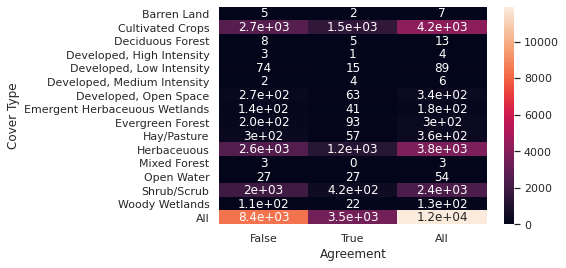

In [13]:
confusion_matrix = pd.crosstab( grid['Legend'],grid['agreement'], rownames=['Cover Type'], colnames=['Agreement'], margins=True)
print (confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)
plt.show()